# Einleitung
Dieses Jupyter-Notebook dient dem Analysieren und Visualisieren der Kommentare in den Bundestagesreden im Plenarsaal.
Im ersten Schritt wurden dahingehend die häufigsten wiederkehrenden Begriffe durch manuelle Suche herausgefiltert und im Gruppenplenum zur weiteren Verwertung für die angestrebte Webseite mittels verschiedener Funktionen in diesem Jupyter-Notebook aufbereitet.
Die Funktionen sind zum einem die Tagesordnungspunkte anhand der Redner je Fraktion in die Parteinennungen zu überführen und anschließend je Partei eine statistische Auswertung von definierten Schlagworten zu untersuchen und nach quantitativen Merkmalen aufzuzeigen. 
Ziel ist somit eine erweiterte Klassifizierung von Zuspruch oder Ablehnung auf Fraktionsebene und somit je Themenbereich ein Meinungsbild für die Fraktionen abzubilden. Somit ist die erweiterte Informationsdarstellung je Thema hinsichtlich einer möglichen Themen-Koalition aufzeigbar. 
Als Datensatz werden die Plenarprotokolle des deutschen Bundestages für die 20. Wahlperiode https://www.bundestag.de/services/opendata zugrundegelegt. Dabei werden Listen für folgende Schlagworte erstellt:
<li>Beifall = positiver Zuspruch und Zustimmung von Fraktionen und/oder einzelnen Personen einer Fraktion</li>
<li>Zuruf = positive Wortmeldung einer Fraktionsperson zur Redner-Partei</li>
<li>Gegenruf = kritische Wortmeldung einer Fraktionspartei zur Redner-Partei</li>
<li>Lachen = situativ-abhängige positive oder negative Reaktion</li>
<li>Widerspruch = gegenteilige Wortmeldung einer Fraktionsperson zur Redner-Partei</li>
<li>Heiterkeit = positives Stimmungsbild einer Fraktion oder einzelnen Personen einer Fraktion</li>
<li>Unsinn = negative Wortmeldung einer Fraktionsperson zur Redner-Partei</li>
Außerdem sind mögliche Themen-Bündnisse klassifizierbar und auch die fraktionslosen Kandidaten werden in der Untersuchung mit berücksichtigt.

# Module und Bibliotheken einbinden
Es sind verschiedene Module und Bibliotheken notwendig, um bereits konzipierte Funktionen beginnend mit "def" aufrufen zu können. Als Softwareverzeichnis mit der jeweiligen Beschreibung sind die jeweiligen Links angegeben:

<li><b>import collections</b> = dieses Modul importiert Standardbibliotheken von Python.
(<a href="https://pypi.org/project/collection">https://pypi.org/project/collection</a>)</li>

<li><b>import json</b> = dieses Modul importiert <b>J</b>ava<b>S</b>cript <b>O</b>bject <b>N</b>otation-Format ins Jupyter-Notebook.
(<a href="https://www.json.org/json-en.html">https://www.json.org/json-en.html</a>)</li>

<li><b>import matplotlib.pyplot</b> = diese Modul dient zur Visualisierung von mathematischen Zusammenhängen.
(<a href="https://matplotlib.org">https://matplotlib.org</a>)</li>

<li><b>import numpy</b> oder kurz <b>np</b> = dieses Modul ermöglicht Python Objektzähler, Counter und Zählen von Wörtern.
(<a href="https://numpy.org">https://numpy.org</a>)</li>

<li><b>import os</b> = dieses Modul ermöglicht Verzeichnisstrukturen verschiedener Betriebssystem zu nutzen.
(<a href="https://docs.python.org/3/library/os.html">https://docs.python.org/3/library/os.html</a>)</li>

<li><b>import re</b> = dieses Modul ermöglicht reguläre Ausdruckssyntax anzuwenden, z.B. Verkettungen.
(<a href="https://docs.python.org/3/library/re.html">https://docs.python.org/3/library/re.html</a>)</li>

<li><b>import request</b> = diese Modul ermöglicht die vereinfachte HTML-Anfrage für Python-Bibliotheken.
(<a href="https://pypi.org/project/requests">https://pypi.org/project/requests</a>)</li>

<li><b>import sys</b> = diese Modul stellt mittels Python-Interpret, z.B. Funktion und Methoden, zur Verfügung.  
(<a href="https://pypi.org/project/os-sys">https://pypi.org/project/os-sys</a>)</li>

In [1]:
import collections
import json
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import pandas as pd
import re
import requests
import sys

# Laden der Bundestagsreden
Alle Reden des deutschen Bundetages für die 20. Wahlpersriode sind in den Plenarprotokollen auf der Webseite des deutschen Bundestages in xml-Dateien abgespeichert. Für einen schnellen Zugriff und zur weiteren Verarbeitungen und einfachen Darstellung von Zwischenschritten und Teilausgaben wird dies mittels des Jupyter-Notebook in das JSON-Format überführt.

Die xml-Dateien der Plenarprotokolle sind in den Ordnern <b>bundestagsreden_parser\data_19</b> und <b>bundestagsreden_parser\data_20</b> abgelegt.
Dazu wird im ersten Schritt mittels des CMD im Ordner <b>"bundestagsreden_parser"</b> das Kommando <b>"python run.py"</b> ausgeführt. Beim Ausführen der Python-Datei können die Reden für die Legislaturperiode 19 oder 20, sowie mit und ohne Kommentarfelder erfolgen.</p>
Wir laden mit dem nachfolgenden Code alle Reden der ausgewählen Legislaturperiode. Die vom Parser erstellten Dateien befinden sich nun unter dem Pfad <b>bundestagsreden\data</b>. Die vom Parser erstellte Datei heißt z.B. <b>speeches_20.jsonl</b> (ohne Kommentare) oder <b>speeches_20_with_comments.jsonl</b> (mit Kommentare).

In [2]:
with open('../../data/speeches_20_with_comments.jsonl', 'r', encoding = 'utf8') as fp:
    data = list(fp)
speeches = []
for line in data:
    speeches.append(json.loads(line))

Mit dem Befehl <b>"len"</b> können wir die Anzahl der Argumente, in unserem Fall: <b>speeches</b> (alle Reden), aus den geladenen Plenarprotokollen ausgeben lassen.

In [3]:
len(speeches)

5062

Wir können nun mit dem Befehl <b>print</b> und dem Index <b>[0]</b> die erste Rede ausgeben. Die folgenden Attribute jeder Rede werden ausgeben:
<table style="margin-left: 0; margin-right: 0;">
    <tr>
        <th style="text-align: left;">Attribut</th>
        <th style="text-align: left;">Beschreibung<th>
    </tr>
    <tr>
        <td style="text-align: left;">'text'</td>
        <td style="text-align: left;">Reden inklusive der Kommentare -> Kommentare werden mittels Parser in {(...)} dargestellt</td>
    </tr>
    <tr>
        <td style="text-align: left;">'id'</td>
        <td style="text-align: left;">zugewiesene ID der einzelnen Rede</td>
    </tr>
    <tr>
        <td style="text-align: left;">'period'</td>
        <td style="text-align: left;">Legislaturperiode in der die Rede gehalten wurde</td>
    </tr>
    <tr>
        <td style="text-align: left;">'date'</td>
        <td style="text-align: left;">Datum der Rede</td>
    </tr>
    <tr>
        <td style="text-align: left;">'name'</td>
        <td style="text-align: left;">Name des/r Redner/in</td>
    </tr>
    <tr>
        <td style="text-align: left;">'party'</td>
        <td style="text-align: left;">zugehörige Partei der/s Redner/in</td>
    </tr>
    <tr>
        <td style="text-align: left;">'redner_id'</td>
        <td style="text-align: left;">ID des/r Redner/in</td>
    </tr>
    <tr>
        <td style="text-align: left;">'discussion_title'</td>
        <td style="text-align: left;">Überschrift (mit Inhalt des Tagesordnungspunktes)</td>
    </tr>
</table></br>
Die Attribute wurden bereits in der geladenen xml-Datei definiert und können durch geeignete Suchfunktion extrahiert werden.

In [4]:
print(speeches[1])

{'text': 'Herr Präsident! Liebe Kolleginnen und Kollegen! Die Konstituierung des Bundestages ist ein Festtag der Demokratie. Und wenn man sich auf der Welt mal umsieht und sich anschaut, wie die Situation anderswo ist, dann muss und darf man festhalten: Dass hier und heute ein unabhängiges, ein frei gewähltes, starkes Parlament zusammenkommt, ist ein Geschenk\xa0– ein Geschenk, auf das wir stolz sein und für das wir dankbar sein können, liebe Kolleginnen und Kollegen. {(Beifall bei der CDU/CSU sowie bei Abgeordneten der SPD, des BÜNDNISSES\xa090/DIE GRÜNEN und der FDP)} Ich sage das deswegen, weil Demokratie ja immer auch ein Streit nach Regeln ist, und diese Regeln geben wir uns mit der Geschäftsordnung, die wir gleich beschließen. Diese Geschäftsordnung hat sich insgesamt bewährt, unser parlamentarisches Miteinander zu organisieren; deswegen werden wir den Antrag der SPD auch unterstützen. Dieses Bewähren gilt insbesondere auch für die Kernaufgaben, die dieses Parlament hat, nämlich 

# Reden mit Kommentaren je Partei filtern
Im ersten Schritt wollen wir alle Parteinamen des Attributs 'party' ausgeben lassen. Dazu erstellen wir die leere Liste <b>party_name</b>. Anschließend wird mittels einer for-Schleife jede Rede von allen Reden durchlaufen. Mittels der if-Bedingung wird verglichen, ob das gefundene Attribut bereits in der Liste <b>party_name</b> enthalten ist. Zwei Möglichkeiten sind hier definiert:</br>
<li>Nein -> gefundene Partei wird in der Liste hinzugefügt</li>
<li>Ja   -> "passen" und die for-Schleife erneut ausführen</li>
Als Ausgabe erhalten wir die Liste <b>party_name</b> mit allen gefundenen Parteinamen im Attribut <b>party</b>.

In [5]:
party_names = []
speeches_per_party = {'BÜNDNIS 90/DIE GRÜNEN': 0, 
                       'CDU/CSU'              : 0,
                       'Fraktionslos'         : 0,
                       'AfD'                  : 0,
                       'SPD'                  : 0,
                       'FDP'                  : 0,
                       'DIE LINKE'            : 0,
                       'unknown'              : 0 }
for speech in speeches:
    if speech['party'] in party_names:
        speeches_per_party[speech['party']] = speeches_per_party[speech['party']] + 1
    else:
        party_names.append(speech['party'])
        speeches_per_party[speech['party']] = 1
party_names # hiermit wird die Liste ausgegeben
speeches_per_party

{'BÜNDNIS 90/DIE GRÜNEN': 813,
 'CDU/CSU': 1122,
 'Fraktionslos': 27,
 'AfD': 674,
 'SPD': 1186,
 'FDP': 680,
 'DIE LINKE': 394,
 'unknown': 166}

Zusätzlich zu den bekannten Parteinamen sehen wir die Bezeichnung <b>unknown</b>. Mittels des Parsers konnte jedoch die gefundene <b>redner_id</b> nicht einer Partei zugeordnet werden. D.h. in diesem Fall sprach der/die Redner/in nicht im Sinne der Fraktion, sondern im Sinne ihres Amtes (z.B. als Minister für Außenpolitik). In der xml-Dateien erhalten die Redner/in eine gesonderte <b>redner_id</b>, so dass die Fraktionszugehörig wegfällt und stattdessen eine Beschreibung der Minister-Position enthält.

Im nächsten Schritt erstellen wir ein <b>Dictionary</b>. Dazu wird zum KEY: 'party' ein leeres Array zugewiesen. In dem jeweiligen Array sind je Partei alle Kommentare von allen Reden einzufügen. Bereits im <b>bundestagsreden parser</b> wurden mögliche verschiedene Schreibweisen von den Parteinamen bereinigt, sodass hier nur die folgenden Parteinamen auftauchen können. Die Schreibweisen im <b>Attribut 'party'</b> haben wir zudem im vorran gegangenen Schritt herausgefunden.<br>
Wichtig ist dabei zu berücksichtigen, dass das Attribut bereits in der xml-Datei definiert wurde und die exakte Schreibweise übernommen werden muss.

In [6]:
comments_to = {'BÜNDNIS 90/DIE GRÜNEN': ['all comments to Grüne'], 
               'CDU/CSU'              : ['all comments to CDU/CSU'],
               'Fraktionslos'         : ['all comments to Fraktionslos'],
               'AfD'                  : ['all comments to AfD'],
               'SPD'                  : ['all comments to SPD'],
               'FDP'                  : ['all comments to FDP'],
               'DIE LINKE'            : ['all comments to Linke'],
               'unknown'              : ['all comments to unknown'] }
comments_to # diese Ausgabe zeigt unser Dictionary und die zugehörigen leeren Arrays

{'BÜNDNIS 90/DIE GRÜNEN': ['all comments to Grüne'],
 'CDU/CSU': ['all comments to CDU/CSU'],
 'Fraktionslos': ['all comments to Fraktionslos'],
 'AfD': ['all comments to AfD'],
 'SPD': ['all comments to SPD'],
 'FDP': ['all comments to FDP'],
 'DIE LINKE': ['all comments to Linke'],
 'unknown': ['all comments to unknown']}

Die Kommentare sind in den xml-Dateien im Attribut <b>'text'</b> enthalten. Durch den Parser wurde bereits um jeden Kommentar Klammern <b>{(...)}</b> ergänzt.<br>
Die nachfolgende Funktion <b>extract_comments</b> extrahiert nun alle Textstellen im Attribut <b>'text'</b> mit den Klammern <b>{(...)}</b> und deren Inhalt. Alle gefundenen Zeichenfolgen <b>{(...)}</b>, werden mit der Python-Operation re.findall in die Liste <b>'comments'</b> eingefügt.</br>
Um das usprüngliche Attribut <b>'text'</b> nicht zu verändern, wird die Liste <b>'comments'</b> als neues Attribut 'comments' an die bestehende Rede angehängt.

In [7]:
def extract_comments(speeches):
    regex = "{(.*?)}" # hier steht die genaue Definition der Kommentare vom Parser
    comments = []
    modified_speeches = []
    for speech in speeches:
        text = speech['text']
        matches = re.findall(regex,text)
        speech['comments'] = matches
        modified_speeches.append(speech)
    return modified_speeches
speeches_comments = extract_comments(speeches) # hier erfolgt der Funktionsaufruf

Jetzt haben wir zum einen alle Parteinamen herausgefiltert und außerdem die zu untersuchenden Kommentare aus der jeweiligen Rede extrahiert und als neues Attribut an die Rede angehängt.</br>
Wir wollen nun die Arrays im erstellten Dictionary befüllen. Dazu iterieren wir mittels einer for-Schleife durch die Liste <b>party_name</b> und füllen das Key mit den gefundenen Parteinamen.
Als nächstes iterieren wir mit der zweiten for-Schleife durch jede Rede. Dabei werden nur Reden mit mindestens einem Kommentaren berücksichtigt.<br>
Desweiteren werden Kommentare die <b>' - '</b> enthalten durch dieses Minus getrennt. D.h. aus dem Kommentar <b>{(... - ...)}</b> wird <b>{(...)},{(...)}</b>. Das heißt der eine Kommentar wird in zwei Kommentare aufgeteilt.<br>
<br>
Als Beispiel folgender Auszug: 

In [8]:
speeches[1]['comments'][5]

'(Beifall bei der CDU/CSU sowie bei Abgeordneten der SPD und der FDP\xa0– Dr.\xa0Alice Weidel [AfD]: Dafür haben Sie auch die Quittung gekriegt!\xa0– Jan Korte [DIE LINKE]: Das war ganz gut!\xa0– Gegenruf der Abg. Dr.\xa0Alice Weidel [AfD]: Na ja!)'

Wir sehen zum einen den Beifall von CDU/CSU, SPD und FDP.<br>
Weiterhin durch <b>' - '</b> abgegrenzt die Wortmeldung von Alice Weidel.<br>
Anschließen nach <b>' - '</b> die Wortmeldung von Jan Korte.<br>
Nach einem erneuten <b>' - '</b> den Gegenruf von Alice Weidel.<br>

D.h. es sind in diesem Auzug 4 Kommentare:
<li>Beifall</li>
<li>spezifische Wortmeldung</li>
<li>spezifische Wortmeldung</li>
<li>Gegenruf</li>
enthalten. Diese werden mittels <b>split(' – ')</b> separiert und können anschließend einzeln ausgewertet werden.

In [9]:
comments_to = {}
for party in party_names:
    comments_to.update({ party : [] })
for speech in speeches:
    if len(speech['comments']) > 0:
        for comment in speech['comments']:
            for split_comment in comment.split(' – '):
                comments_to[speech['party']].append(split_comment)

Die Dictionary's sind nun auf Grundlage der Liste <b>party_name</b> befüllt und können nun zur weiteren Analyse verwendet werden.
# Kommtare auswerten
Als erstes definieren wir eine Liste mit allen spezifischen Begriffen mit denen wir die erstellten Dictionary's untersuchen.

In [10]:
list_keywords = ['Beifall','Zuruf','lachen','Widerspruch','Heiterkeit','Unsinn','Gegenruf']

Desweiteren sind verschiedene Schreibweisen der jeweiligen Fraktionsnennungen in den Kommentaren der Plenarprotokolle vorzufinden. Somit ist es notwendig eine Liste des Wortstammes aller Parteinamen zu generieren.<br>

In [11]:
party_search_string = ['LINKE','SPD','GRÜNE','CDU','FDP','AfD','fraktionslos','unknown']

Damit wir durch unsere Liste von den gefunden Parteinamen durch iterieren können, benötigen wir die Anzahl der gefundenen Parteneinamen.

In [12]:
nParties = len(party_names)

Die  Funktion <b>matrix_per_Keyword</b> erstellt uns nun je nach Keyword eine 2x2-Matrix. Dabei wird als erstes eine 2x2-Matrix mit Null befüllt. Außerdem wird mittels des <b>dtype = np.int32</b> der Datentyp uint32 zugewiesen, d.h. es werden positive, natürliche Zahlen dargestellt.<br>
Mittels der ersten for-schleife gehen wir nun in unser Dictionary <b>comments_to</b>. Dazu wird mittels der Python-Funktion <b>enumerate()</b> die Syntax <b>enumerate(iterable, start)</b> [1] gestartet. Hierbei wird <b>px</b> mit Null begonnen und 'start' ist xparty, d.h. der erste Parteiname aus unserem Dictionary. Sind die nachfolgenden for-Schleifen abgeschlossen wird <b>px</b> um Eins hoch gezählt.<br>
Die zweite for-Schleife nimmt nun Zugriff auf das Array der vorran ausgewählten Partei.<br>
Die dritte for-Schleife zählt wieder mittels <b>enumerate()</b> diesmal in unserer <b>party_search_string</b> hoch, weil  die Benennung der Partnamen innerhalb der Kommentare verschieden sind. Ist eine Benennung inklusive unseres Keyword innerhalb eines Kommentar's gefunden, so wird <b>py</b> um Eins hoch gezählt.

In [16]:
def matrix_per_Keyword (keyword):
    matrix_with_keyword = []
    dimension = np.zeros((nParties,nParties),dtype = np.float16)
    for px,xparty in enumerate(comments_to): # xparty ist der Partyname aus dem dict
        for comment in comments_to[xparty]:  # Zugriff auf das Array der ausgewälten Partei
            for py,yparty in enumerate(party_search_string):
                if yparty in comment and keyword in comment:
                    dimension[px,py] = dimension[px,py] + 1
    return dimension
    return matrix_with_keyword

In [23]:
normalize_count = np.zeros((nParties,nParties),dtype = np.float16)
dimension = matrix_per_Keyword('Beifall')
for px,xparty in enumerate(comments_to): # xparty ist der Partyname aus dem dict
    print(speeches_per_party[xparty])
    for py,yparty in enumerate(comments_to):
        normalize_count[px,py] = dimension[px,py] / speeches_per_party[xparty]
normalize_count

1186
1122
813
680
674
394
166
27


array([[5.8203e-01, 1.7266e+00, 1.7266e+00, 1.1143e+00, 1.7266e+00,
        5.5322e-01, 5.9013e-03, 0.0000e+00],
       [2.5049e-01, 1.5664e+00, 1.5176e+00, 1.8252e+00, 1.3203e+00,
        6.1035e-01, 8.9121e-04, 0.0000e+00],
       [6.8164e-01, 2.5195e+00, 2.5195e+00, 1.1123e+00, 2.5195e+00,
        4.8096e-01, 3.6907e-03, 0.0000e+00],
       [6.0303e-01, 3.0117e+00, 3.0117e+00, 1.3975e+00, 3.0117e+00,
        3.9697e-01, 1.4706e-03, 0.0000e+00],
       [1.6614e-01, 1.1514e+00, 1.0625e+00, 1.8689e-01, 8.4277e-01,
        3.0391e+00, 8.9050e-02, 0.0000e+00],
       [5.1992e+00, 1.4443e+00, 1.3477e+00, 4.5435e-01, 1.0508e+00,
        4.0356e-01, 0.0000e+00, 0.0000e+00],
       [9.4580e-01, 3.0605e+00, 3.0234e+00, 8.6768e-01, 2.7891e+00,
        2.4695e-01, 0.0000e+00, 0.0000e+00],
       [1.1855e+00, 2.0742e+00, 1.8887e+00, 4.4434e-01, 1.4814e+00,
        6.6650e-01, 7.4097e-02, 0.0000e+00]], dtype=float16)

Wir rufen nun die Funktion <b>matrix_per_Keyword</b> für das Keyword <b>Beifall</b> auf. Außerdem geben wir dann die 2x2-Matrix aus.<br>
Die Matrix selbst kann dahingehend noch nicht aussagekräftig beurteilt werden, da uns die genaue Zurodnung von der Redner-Partei und den jeweiligen Reaktions-Parteien verborgen sind.

In [ ]:
len(speeches)

In [ ]:
relations_Beifall = matrix_per_Keyword(list_keywords[0])
print(relations_Beifall)

Wir definieren eine Print-Ausgabe, um die Beschreibung in Textform zu generieren. 

In [ ]:
def print_relation_per_Keyword(relations,parties):
    for x,xparty in enumerate(parties):
        for y,yparty in enumerate(parties):
            print(f'{list_keywords[0]} für Redner {xparty} von Partei {yparty}: {relations[x,y]}')
print_relation_per_Keyword(relations_Beifall,party_search_string)

Wir können nun die Textausgaben und die Matrix vergleichen und stellen fest, dass je Zeile die Redner-Partei dargestellt ist und je Spalte  die Anzahl der Reaktions-Partei abgelesen werden können. In diesem Fall sehen wir die Ausgabe für das <b>Keyword: Beifall</b>. Zur besseren Darstellung sind diese in Tabellenform dargestellt und die Nummerierung mittels Partei-Zuordnung ablesbar. 

In [ ]:
dataset = pd.DataFrame({f'0={party_search_string[0]}': relations_Beifall[:, 0],
                        f'1={party_search_string[1]}': relations_Beifall[:, 1],
                        f'2={party_search_string[2]}': relations_Beifall[:, 2],
                        f'3={party_search_string[3]}': relations_Beifall[:, 3],
                        f'4={party_search_string[4]}': relations_Beifall[:, 4],
                        f'5={party_search_string[5]}': relations_Beifall[:, 5],
                        f'6={party_search_string[6]}': relations_Beifall[:, 6],
                        f'7={party_search_string[7]}': relations_Beifall[:, 7]})
print(dataset)

Wir können nun für alle Keywords diese in einer 2x2-Matrix ausgeben lassen und verstehen jeweils den Zusammenhang von Redner-Partei und der zugehören Anzahl der Reaktions-Parteien. Die folgenden Ausgabe sind auskommentiert, da wir im nächsten Schritt die Matrizen als Balkendiagramm ausgeben werden.

In [ ]:
relations_Zuruf = matrix_per_Keyword(list_keywords[1]) # Beifall,Zuruf,lachen,Widerspruch,Heiterkeit,Unsinn,Gegenruf
# print(relations_Zuruf)

In [ ]:
relations_lachen = matrix_per_Keyword(list_keywords[2]) # Beifall,Zuruf,lachen,Widerspruch,Heiterkeit,Unsinn,Gegenruf
# print(relations_lachen)

In [ ]:
relations_Widerspruch = matrix_per_Keyword(list_keywords[3]) # Beifall,Zuruf,lachen,Widerspruch,Heiterkeit,Unsinn,Gegenruf
# print(relations_Widerspruch)

In [ ]:
relations_Heiterkeit = matrix_per_Keyword(list_keywords[4]) # Beifall,Zuruf,lachen,Widerspruch,Heiterkeit,Unsinn,Gegenruf
# print(relations_Heiterkeit)

In [ ]:
relations_Unsinn = matrix_per_Keyword(list_keywords[5]) # Beifall,Zuruf,lachen,Widerspruch,Heiterkeit,Unsinn,Gegenruf
# print(relations_Unsinn)

In [ ]:
relations_Gegenruf = matrix_per_Keyword(list_keywords[6]) # Beifall,Zuruf,lachen,Widerspruch,Heiterkeit,Unsinn,Gegenruf
# print(relations_Gegenruf)

Zur besseren Lesbarkeit der Daten werden die voran erstellten Matrizen als Balkendiagramme dargestellt. Dazu definieren wir die Funktion <b>bar_plot</b> mit allen notwendigen Parametern.

In [24]:
def bar_plot(keyword):
    #data = matrix_per_Keyword(keyword); # Matrix je Keyword
    data = normalize_count
    index = np.arange(nParties);        # erstellt Array aufgrund Anz. Parteien bzw. untersch. Attribute 'Party' 
    fig,ax = plt.subplots();            # Definition für Fkt. .supplots()
    fig.set_figheight(10);              # Höhe des gesamten Diagramms
    fig.set_figwidth(15);               # Breite des gesamten Diagramms
    width = (nParties/10)/nParties;     # Definition der allg. Breite aufgrund untersch. Anzahl 'Party'
    edgecolor = 'black';                # Konturfarbe der einzelnen Balken
    rects_0 = ax.bar(index - 6*width/2, data[:,0], color = 'magenta', edgecolor=edgecolor, width=width);
    # Balkenposition, Balkenlänge, Balkenfarbe, Balkenbreite je Partei
    rects_1 = ax.bar(index - 4*width/2, data[:,1], color = 'red'    , edgecolor=edgecolor, width=width);
    rects_2 = ax.bar(index - 2*width/2, data[:,2], color = 'green'  , edgecolor=edgecolor, width=width);
    rects_3 = ax.bar(index + 0*width/2, data[:,3], color = 'black'  , edgecolor=edgecolor, width=width);
    rects_4 = ax.bar(index + 2*width/2, data[:,4], color = 'yellow' , edgecolor=edgecolor, width=width);
    rects_5 = ax.bar(index + 4*width/2, data[:,5], color = 'blue'   , edgecolor=edgecolor, width=width);
    rects_6 = ax.bar(index + 6*width/2, data[:,6], color = 'white'  , edgecolor=edgecolor, width=width);
    ax.set_title(f'Häufigkeiten zum Keyword: {keyword}', fontsize = 18); # Diagramm-Titel
    ax.set_xlabel('Redner-Partei', fontsize = 12);                       # Beschriftung x-Achse
    ax.set_ylabel('Häufigkeit der Reaktion', fontsize = 12)              # Beschriftung y-Achse
    ax.set_xticks(index);                                                # Array für Balkenschriftung
    ax.set_xticklabels(party_search_string);                             # Array für Balkenschriftung Textinhalt
    ax.legend(party_search_string);                                      # Diagramm Legende
    rotation = 90;                                                       # Drehwinkel 90° für Texte
    padding = 5;                                                         # Textabstand 5
    ax.bar_label(rects_0, padding=padding, rotation=rotation); # Beschriftung des 1.Balken je Redner-Partei
    ax.bar_label(rects_1, padding=padding, rotation=rotation);
    ax.bar_label(rects_2, padding=padding, rotation=rotation);
    ax.bar_label(rects_3, padding=padding, rotation=rotation);
    ax.bar_label(rects_4, padding=padding, rotation=rotation);
    ax.bar_label(rects_5, padding=padding, rotation=rotation);
    ax.bar_label(rects_6, padding=padding, rotation=rotation); # Beschriftung des 7.Balken je Redner-Partei
    fig.tight_layout();
    return plt.show();

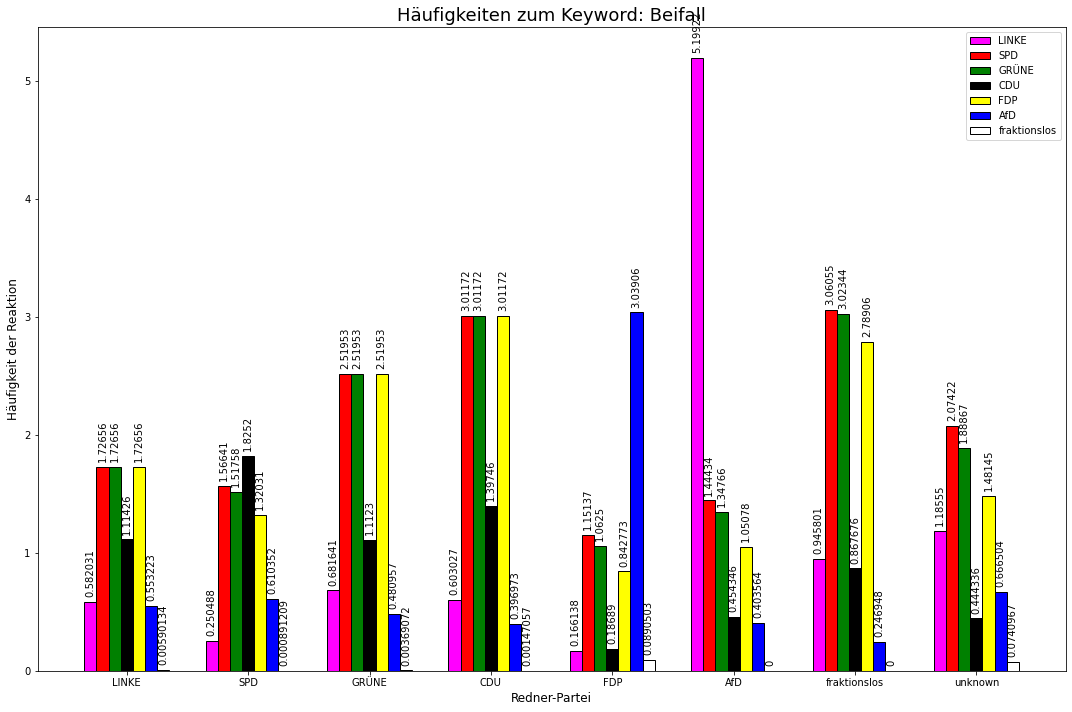

None


In [25]:
barplot_beifall = bar_plot(list_keywords[0]) # 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_beifall);

In [ ]:
barplot_Zuruf = bar_plot(list_keywords[1]) # 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_Zuruf)

In [ ]:
barplot_Lachen = bar_plot(list_keywords[2]) # 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_Lachen)

In [ ]:
barplot_Widerspruch = bar_plot(list_keywords[3])# 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_Widerspruch)

In [ ]:
barplot_Heiterkeit = bar_plot(list_keywords[4])# 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_Heiterkeit)

In [ ]:
barplot_Unsinn = bar_plot(list_keywords[5])# 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_Unsinn)

In [ ]:
barplot_Gegenruf = bar_plot(list_keywords[6])# 0=Beifall 1=Zuruf 2=Lachen 3=Widerspruch 4=Heiterkeit 5=Unsinn 6=Gegenruf
print(barplot_Gegenruf)

Wir können aufgrund der visuellen Darstellungen nun auf einen Blick die Häufigkeiten der Reaktion für jede Redner-Partei ablesen. Es sind verschiedene Tendenzen bzgl. von Zustimmungen als auch Ablehnungen (je <b>Keyword</b>) ersichtlich. Daraus schlussfolgernd können nun Reden nach Themen gefiltert werden und daraus spezifische Koalitionen und Opposition abgebildet werden. D.h. es sind auch unabhängig "Bündnisse" von Regierungsparteien und Regierungsopposition als Stimmungsbilder von verschiedenen Themen darstellbar.

# Literaturverzeichnis:
[1] https://www.w3schools.com/python/ref_func_enumerate.asp